In [2]:
import os, sys

current_path = '/content/drive/My Drive/Colab Notebooks/Project_Stock/'

os.chdir(current_path)

In [2]:
# !ls

### LOAD OHLCV

In [2]:
def min_max_scaler(x):
    scaled_x = (x - x.min()) / (x.max() - x.min())
    return scaled_x

In [1]:
!pip install pandas==0.25.3
!pip install pmdarima 

In [3]:
import pickle

interval = '30m'
with open('./arima_result/arima_candi_profit_result_%s.pickle' % interval, 'rb') as f:
  profit_result_dict = pickle.load(f)

print(list(profit_result_dict.keys()))

['2021-02-11 ZECUSDT.xlsx', '2021-02-11 BNBUSDT.xlsx', '2021-02-11 KAVAUSDT.xlsx', '2021-02-11 XTZUSDT.xlsx', '2021-02-11 SXPUSDT.xlsx', '2021-02-11 ONTUSDT.xlsx', '2021-02-11 BANDUSDT.xlsx', '2021-02-11 QTUMUSDT.xlsx', '2021-02-11 NEOUSDT.xlsx', '2021-02-11 DASHUSDT.xlsx', '2021-02-11 ATOMUSDT.xlsx', '2021-02-11 IOTAUSDT.xlsx', '2021-02-11 DOTUSDT.xlsx', '2021-02-11 MKRUSDT.xlsx', '2021-02-11 THETAUSDT.xlsx', '2021-02-11 WAVESUSDT.xlsx', '2021-02-11 BATUSDT.xlsx', '2021-02-11 ZRXUSDT.xlsx', '2021-02-11 SNXUSDT.xlsx', '2021-02-11 ALGOUSDT.xlsx', '2021-02-11 OMGUSDT.xlsx', '2021-02-11 KNCUSDT.xlsx', '2021-02-11 COMPUSDT.xlsx', '2021-02-11 BTCUSDT.xlsx', '2021-02-11 ETHUSDT.xlsx', '2021-02-11 BCHUSDT.xlsx', '2021-02-11 XRPUSDT.xlsx', '2021-02-11 EOSUSDT.xlsx', '2021-02-11 LTCUSDT.xlsx', '2021-02-11 ETCUSDT.xlsx', '2021-02-11 LINKUSDT.xlsx', '2021-02-11 XLMUSDT.xlsx', '2021-02-11 ADAUSDT.xlsx', '2021-02-11 XMRUSDT.xlsx']


In [4]:
from statsmodels.tsa.arima_model import ARIMA


def arima_test(close, use_rows=None):

  size = int(len(close) * 0.66)
  train, test = close[0:size].values, close[size:len(close)]
  test_shift = test.shift(1).values
  test = test.values
  # break

  history = list(train)
  predictions = list()
  err_ranges = list()
  for t in range(len(test)):
    
      if use_rows is not None:
        history = history[-use_rows:]
        
      model = ARIMA(history, order=(0, 2, 1))
      model_fit = model.fit(trend='c', disp=0)
      output = model_fit.forecast()
      # print(output)
      # break
      yhat = output[0]
      predictions.append(yhat)
      err_ranges.append(output[1])
      obs = test[t]
      # print('obs :', obs)
      history.append(obs)
      # break
      print('\r %.2f%%' % (t / len(test) * 100), end='')

  print(len(test), len(predictions))

  return predictions, err_ranges


# print(high)


def get_back_result(ohlcv, predictions, err_ranges, tp=0.04, leverage=1, show_detail=False, show_plot=False):

  
  high, low, test = np.split(ohlcv.values[-len(predictions):, [1, 2, 3]], 3, axis=1)

  fee = 0.0006
  profits = list()
  win_cnt = 0
  for i in range(len(test)):

    long_ep = (predictions[i] - err_ranges[i]) * (1 / (tp + 1))
    short_ep = (predictions[i] + err_ranges[i]) * (1 / (1 - tp))
    # print((low[i]))
    if low[i] < long_ep:
      
      liquidation = low[i] / long_ep - fee
      l_liquidation = 1 + (liquidation - 1) * leverage
      if max(l_liquidation, 0) == 0:
        l_profit = 0
      else:
        profit = test[i] / long_ep - fee
        l_profit = 1 + (profit - 1) * leverage
        l_profit = max(l_profit, 0)
        
        if profit >= 1:
          win_cnt += 1

      profits.append(l_profit)

      if show_detail:
        print(test[i], predictions[i], long_ep)

    elif high[i] > short_ep:

      liquidation = short_ep / high[i]  - fee
      l_liquidation = 1 + (liquidation - 1) * leverage
      if max(l_liquidation, 0) == 0:
        l_profit = 0
      else:
        profit = short_ep / test[i] - fee
        l_profit = 1 + (profit - 1) * leverage
        l_profit = max(l_profit, 0)

        if profit >= 1:
          win_cnt += 1

      profits.append(l_profit)

      if show_detail:
        print(test[i], predictions[i], short_ep)
    
    else:
      profits.append(1.0)

  win_ratio = win_cnt / sum(np.array(profits) != 1.0)
  frequency = sum(np.array(profits) != 1.0) / len(test)
  accum_profit = np.array(profits).cumprod()

  # print(win_ratio)

  if show_plot:
    plt.plot(profits)
    plt.title('Win Ratio : %.2f %% Frequency : %.2f %%' % (win_ratio * 100, frequency * 100), color='white')
    plt.show()

    # print()
    plt.plot(accum_profit)
    plt.title('Accum_profit : %.2f' % accum_profit[-1], color='white')
    plt.show()

  return win_ratio, frequency, accum_profit[-1], profits


# get_back_result(tp=0.04, leverage=1, show_plot=True)


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pyESN.pyESN import ESN
from statsmodels.tsa.arima_model import ARIMA
import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

n_reservoir= 500
sparsity=0.2
rand_seed=23
spectral_radius = 1.2
noise = .0005


esn = ESN(n_inputs = 1,
      n_outputs = 1, 
      n_reservoir = n_reservoir,
      sparsity=sparsity,
      random_state=rand_seed,
      spectral_radius = spectral_radius,
      noise=noise)

keys = list(profit_result_dict.keys())
key = keys[1]
for key in keys:

  try:
    # if key == keys[0]:
    #   continue

    print(key)

    ohlcv = profit_result_dict[key]['ohlcv']
    # print(len(ohlcv))
    # print(ohlcv.head())

    close = ohlcv.iloc[:, [3]].values
    print('close.shape :', close.shape)
    data = close

    err_ranges = profit_result_dict[key]['err_ranges']

    trainlen = 3000
    future = 1
    futureTotal= len(err_ranges)
    pred_tot=np.zeros(futureTotal)

    # predictions = list()
    progress = 0
    for i in range(0, futureTotal, future):
        
        pred_training = esn.fit(np.ones(trainlen), data[-futureTotal - trainlen + i :-futureTotal + i])
        prediction = esn.predict(np.ones(future))
        pred_tot[i:i+future] = prediction[:,0]

        progress += 1
        print('\r %.2f%%' % (progress / (futureTotal // future) * 100), end='')

    tp_list = np.arange(0.001, 0.1, 0.0001)

    temp_ap_list = list()

    for tp in tp_list:

        # progress_cnt += 1
        # print('\r %.2f%%' % (progress_cnt / len(tp_list) * 100), end='')

        # for leverage in leverage_list:

        try:
          result = get_back_result(ohlcv, pred_tot, err_ranges, tp=tp, leverage=1)
          temp_ap_list.append(result[2])

        except Exception as e:
          print(e)
          break

    profit_result_dict[key]['esn_ap_list'] = temp_ap_list
    print(len(temp_ap_list))
    # break

    with open('./arima_result/arima_esn_profit_result_%s.pickle' % interval, 'wb') as f:
       pickle.dump(profit_result_dict, f)

  except Exception as e:
    print(e)
    pass

2021-02-11 ZECUSDT.xlsx
close.shape : (14448, 1)
 100.00%

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:97: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


990
2021-02-11 BNBUSDT.xlsx
close.shape : (14448, 1)
 100.00%

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:96: RuntimeWarning: invalid value encountered in long_scalars


990
2021-02-11 KAVAUSDT.xlsx
close.shape : (9520, 1)
 100.00%990
2021-02-11 XTZUSDT.xlsx
close.shape : (14448, 1)
 100.00%990
2021-02-11 SXPUSDT.xlsx
close.shape : (9852, 1)
 100.00%990
2021-02-11 ONTUSDT.xlsx
close.shape : (14448, 1)
 100.00%990
2021-02-11 BANDUSDT.xlsx
close.shape : (9472, 1)
 100.00%990
2021-02-11 QTUMUSDT.xlsx
close.shape : (14448, 1)
 100.00%990
2021-02-11 NEOUSDT.xlsx
close.shape : (14448, 1)
 100.00%990
2021-02-11 DASHUSDT.xlsx
close.shape : (14448, 1)
 100.00%990
2021-02-11 ATOMUSDT.xlsx
close.shape : (14448, 1)
 100.00%990
2021-02-11 IOTAUSDT.xlsx
close.shape : (14448, 1)
 100.00%990
2021-02-11 DOTUSDT.xlsx
close.shape : (8320, 1)
 100.00%990
2021-02-11 MKRUSDT.xlsx
close.shape : (8752, 1)
 100.00%990
2021-02-11 THETAUSDT.xlsx
close.shape : (12494, 1)
 100.00%990
2021-02-11 WAVESUSDT.xlsx
close.shape : (8800, 1)
 100.00%990
2021-02-11 BATUSDT.xlsx
close.shape : (14448, 1)
 100.00%990
2021-02-11 ZRXUSDT.xlsx
close.shape : (11148, 1)
 100.00%990
2021-02-11 SNXUS

In [1]:

for key in keys:
  print(key)
  print(len(profit_result_dict[key]['esn_ap_list']))
  print()

NameError: ignored

### **Comparing results**

In [36]:
tp_list = np.arange(0.001, 0.1, 0.0001)

temp_ap_list = list()
temp_ap_list2 = list()

for tp in tp_list:

    # progress_cnt += 1
    # print('\r %.2f%%' % (progress_cnt / len(tp_list) * 100), end='')

    # for leverage in leverage_list:

    try:
      result = get_back_result(ohlcv, predictions, err_ranges, tp=tp, leverage=1)
      temp_ap_list.append(result[2])
      result2 = get_back_result(ohlcv, pred_tot, err_ranges, tp=tp, leverage=1)
      temp_ap_list2.append(result2[2])

    except Exception as e:
      print(e)
      break

print(max(temp_ap_list))
print(max(temp_ap_list2))

1.2128848716932112e-189
1.0261609969964424e-189


#### **3000 train (1-tick pred)**

arima mse : 0.00025459660999347923
esn mse : 5.9244215182400656e-05
arima_mse > esn_mse : True


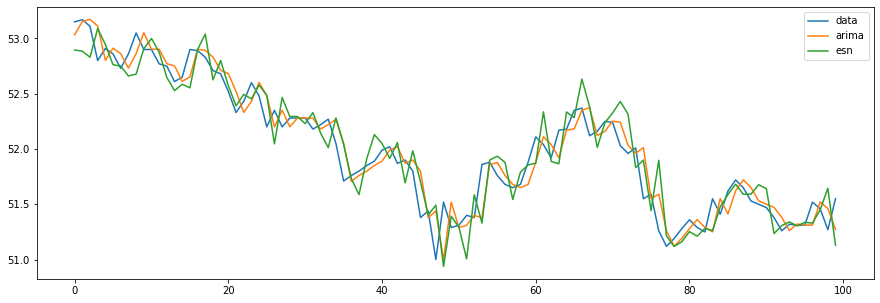

In [22]:
# print(len(pred_tot)) # 대응되는 data => data[1500:1600] => data[trainlen:trainlen + futureTotal]

arima_mse = np.square(np.subtract(data[trainlen:trainlen + futureTotal], predictions).mean())
esn_mse = np.square(np.subtract(data[trainlen:trainlen + futureTotal], pred_tot).mean())
print('arima mse :', arima_mse)
print('esn mse :', esn_mse)
print('arima_mse > esn_mse :', arima_mse > esn_mse)

plt.figure(figsize=(15, 5))
plt.plot(data[trainlen:trainlen + futureTotal], label='data')
plt.plot(predictions, label='arima')
plt.plot(pred_tot, label='esn')
plt.legend()